# NLP for detecting Fake news article

## Libraries

In [1]:
# for processing data
import pandas as pd
import numpy as np 
import nltk 
from nltk.corpus import stopwords
import re

# for building a model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import feature_extraction, model_selection, pipeline, feature_selection, metrics

## Functions

In [2]:
def load_data(directory_Fake_news = 'News_dataset/Fake.csv', directory_True_news = 'News_dataset/True.csv'):
    '''
    Loading data from csv files into dataframe 
    Parameters
    ----------
    directory_Fake_news: string
        location of csv file with fake news
    directory_True_news: string
        locetion of csv file with true news
    Returns
    -------
    df: dataframe
        dataframe with fake and true news titles merged and labeled 1 if true news, 0 if fake news
    '''
    df_fake = pd.read_csv(directory_Fake_news)
    df_fake['target'] = [0]*len(df_fake)
    df_fake = df_fake[['title', 'target']].copy()

    df_true = pd.read_csv(directory_True_news)
    df_true['target'] = [1]*len(df_true)
    df_true = df_true[['title', 'target']].copy()

    df = pd.concat((df_fake, df_true), axis=0, ignore_index=True)
    return df
    

In [3]:
def preprocess_text(text, stopwords = None, flag_lemm = False):
    '''
    Preprocessing of a text - removing special characters, stopwords and converting to root words
    Parameters
    ----------
    text: string
        input text to process
    stopwords: list
        a list of stopwords to remove from text
    flag_lemm: bool
        a flag to identify if lemmatization is needed
    Returns
    -------
    text: string
        a processed string
    '''
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    list_text = text.split() 
    
    if stopwords is not None:
        list_text = [word for word in list_text if word not in stopwords] 
        
    if flag_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        list_text = [lem.lemmatize(word) for word in list_text]    
        
    text = " ".join(list_text)
    return text

In [4]:
def preprocess_data(df):
    stopwords = nltk.corpus.stopwords.words("english")
    df["title"] = df["title"].apply(lambda x: preprocess_text(x, stopwords=stopwords, flag_lemm=True))
    return df

In [5]:
def create_features_and_model(X_train, y_train):
    '''
    Creating features for Bag-of-Words model with Tf-Idf 
    Parameters
    ----------
    X_train: pandas.Series
        training data: texts, from which to built features
    y_train: pandas.Series
        training data labels
    Returns
    -------
    model: pipeline
        a pipeline of a model
    X_train: scipy.sparse.csr.csr_matrix
        matrix with features
    '''
    # create feature matrix
    vectorizer = feature_extraction.text.TfidfVectorizer(max_features=30000, ngram_range=(1,2))
    corpus = X_train
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    # feature selection for dimensionaluty reduction of matrix
    X_names = vectorizer.get_feature_names()
    p_value_limit = 0.95
    df_features = pd.DataFrame()
    for class_news in np.unique(y_train):
        chi2, p = feature_selection.chi2(X_train, y_train==class_news)
        df_features = df_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":class_news}))
        df_features = df_features.sort_values(["y","score"], ascending=[True,False])
        df_features = df_features[df_features["score"]>p_value_limit]
    X_names = df_features["feature"].unique().tolist()
    # final reduced feature matrix
    vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    #models
    classifier = LogisticRegression()
    model = pipeline.Pipeline([("vectorizer", vectorizer),("classifier", classifier)])
    return model, X_train

In [6]:
def train(X_train, y_train, model):
    model["classifier"].fit(X_train, y_train)
    return model

In [7]:
def test(X_test, y_test, model):
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    return predicted, predicted_prob

## Building and testing model

In [8]:
df_raw = load_data()

In [9]:
df = preprocess_data(df_raw)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['target'], 
                                                    test_size=0.2, random_state=42, shuffle=True)

In [11]:
model_template, X_train = create_features_and_model(X_train, y_train)

In [12]:
model = train(X_train, y_train, model_template)
result = test(X_test, y_test, model)

## Plotting the results

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
predicted, predicted_prob = result
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])
cm = metrics.confusion_matrix(y_test, predicted)

In [15]:
print("Accuracy:",  accuracy)
print("Auc score:", auc)

Accuracy: 0.9349665924276169
Auc score: 0.9820290740021503


### Confusion matrix

[Text(0.5, 15.0, 'Predicted'),
 Text(33.0, 0.5, 'Actual'),
 [Text(0.5, 0, 'Fake news'), Text(1.5, 0, 'True news')],
 [Text(0, 0.5, 'Fake news'), Text(0, 1.5, 'True news')],
 Text(0.5, 1.0, 'Confusion matrix')]

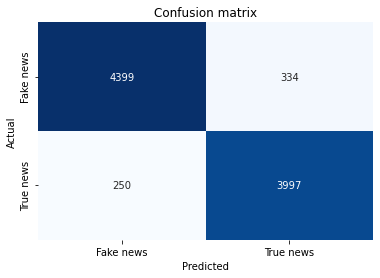

In [16]:
fig, ax = plt.subplots()
sns.heatmap(cm, cmap=plt.cm.Blues, cbar=False, annot=True, fmt='d', ax=ax)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=['Fake news','True news'], yticklabels=['Fake news','True news'], title="Confusion matrix")